<a href="https://colab.research.google.com/github/elhamkashi/DSPS_EKashi/blob/main/HW6%5CSecond_Half_fitlinetogrbafterglow_mcmc_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pylab as plt
# you will need more imports, put them here
from scipy.optimize import minimize



# HW part 1

## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [5]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


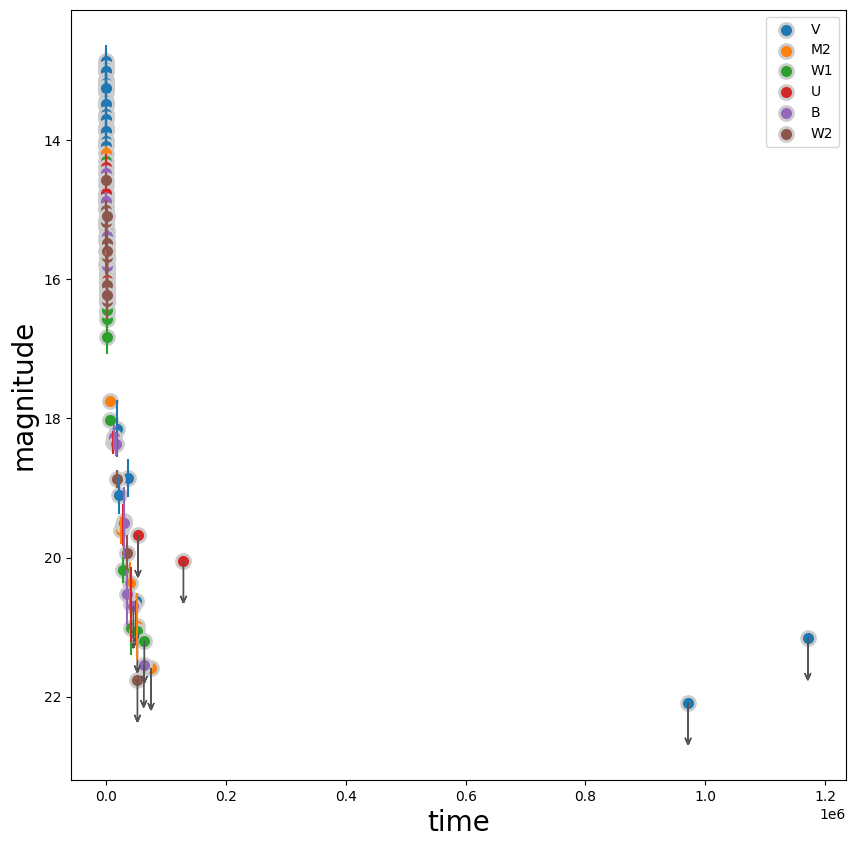

In [6]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

## Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [7]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [8]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

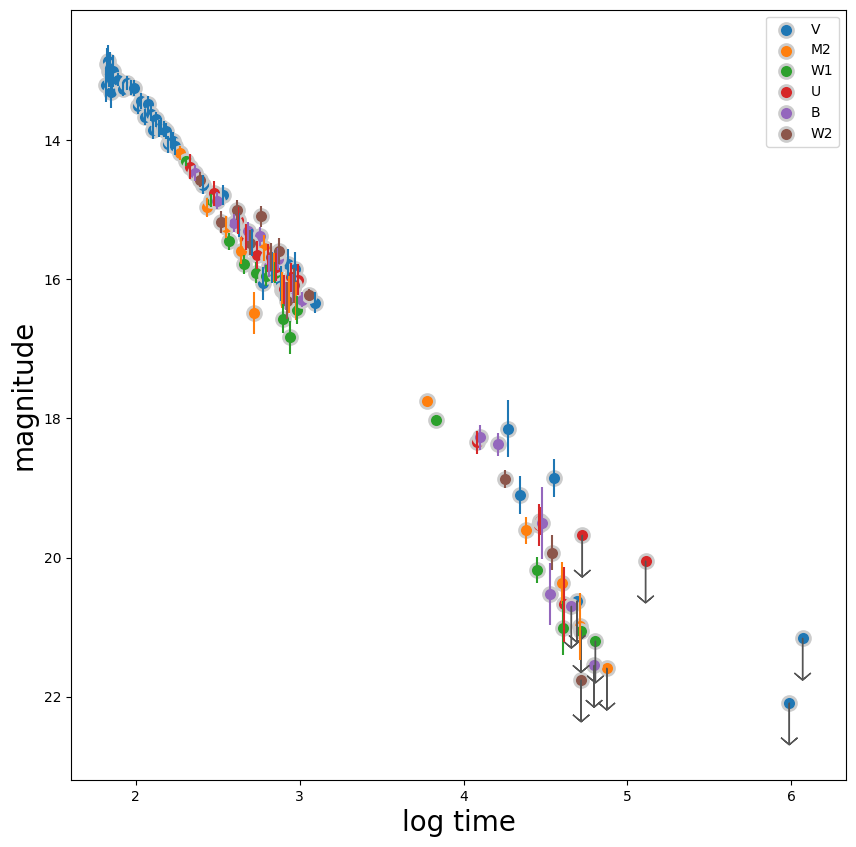

In [ ]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [10]:
grbAGnouplim =  grbAG[grbAG["upperlimit"] == 0]# remove the upper limits from the dataframe to simplify the analysis

In [11]:
x = grbAGnouplim.logtime.values
#pick a function to expand the axis
#option 1
X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 np.dstack((np.ones((X.shape[0])) ,X))


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [12]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [13]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
print(f"slope {lr.coef_[1]:.2f} and intercept {lr.intercept_:.2f}")

slope 2.51 and intercept 8.58


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [14]:
#note: imports should be moved to the top cell - follow PEP8 guidelines


def line(intercept, slope, x):
    '''returns a line
    args:
    intercept: float
    slope: float
    x: array-like of exogenous variables
    '''
    return intercept + slope * x

def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 abs value of difference between prediction and data squared
    '''
    a, b = args
    return np.sum(np.abs(line(a, b, x) - y))


initialGuess = (2, 8)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "intercept {:.2f}, slope {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30332889501873
        x: [ 8.225e+00  2.641e+00]
      nit: 14
      jac: [-1.254e-01 -2.083e+00]
 hess_inv: [[ 2.054e-02 -4.529e-03]
            [-4.529e-03  1.001e-03]]
     nfev: 300
     njev: 96

best fit parameters from the minimization of L1: intercept 8.23, slope 2.64


In [15]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((line(a, b, x) - y)**2)


initialGuess = (2, 8)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "intercept {:.2f}, slope {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725498
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [-1.192e-07 -3.576e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: intercept 8.58, slope 2.51


In [ ]:
l2?

In [ ]:
l1?

## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [16]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((line(a, b, x) - y)**2 / s**2)


x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

initialGuess = 8, 2

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "intercept {:.2f}, slope {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013056
        x: [ 8.599e+00  2.480e+00]
      nit: 7
      jac: [-1.907e-05 -1.526e-05]
 hess_inv: [[ 3.314e-03 -2.853e-03]
            [-2.853e-03  2.473e-03]]
     nfev: 125
     njev: 38

best fit parameters from the minimization of the chi squared: intercept 8.60, slope 2.48


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


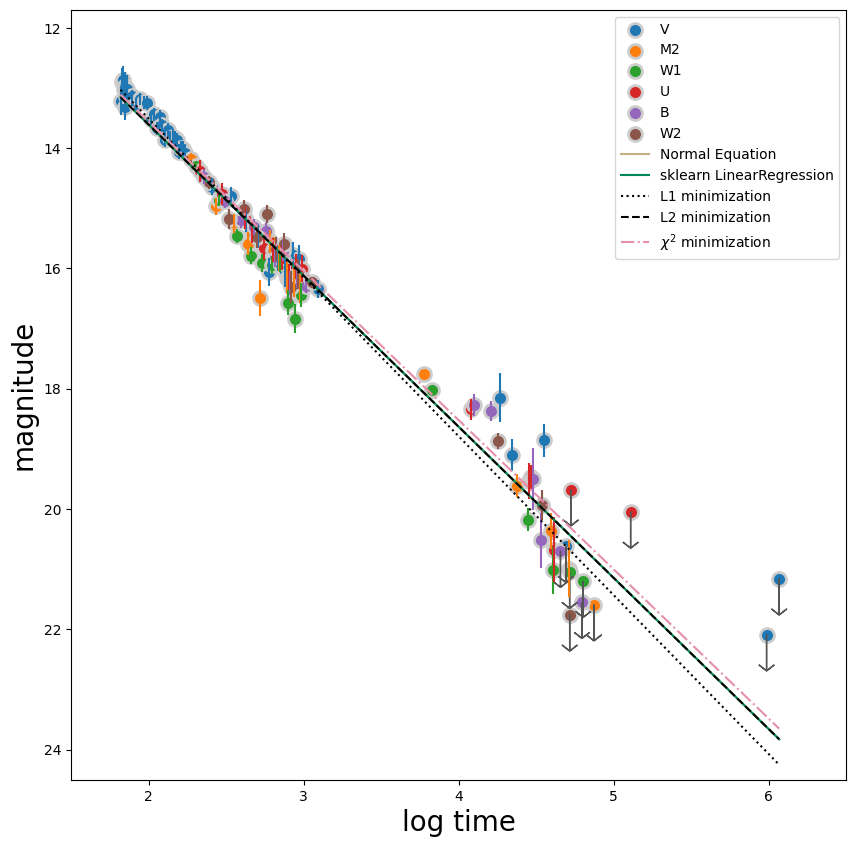

In [17]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


# RERWITE THIS CAPTION!

I gave my caption to chatgpt to revise, it gives:

Given plot shows photometry of GRB afterglow in magnetiude-logtime space, with excluded upper limits and across multiple filters (V, M2, W1, U, B, and W2). This figure compares linear regression models fitted using different optimization methods on gamma-ray burst afterglow data. What's noticeable is how the various methods (Normal Equation sklearn, L1/L2 minimization, and chi-squared) produce slightly different slope and intercept parameters, resulting in divergent model predictions especially at the extremes of the time range. At early prids of time, higher amount of data are fitted with these line models, however, in later time, the data pattern changes slightly and are scattered around these lines and is not fitted by the current slope range around 2.51! Another intersting thing, is the time interval (~ 3-4 in logtime) between these two slope patterns, such that just after the perfect fitting, for a sensible amount of time, there is no observed data, and after this time, scattered data happens. Legend shows different applied models.

# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91, 2), (91,), (17, 2), (17,))

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"score on the training set {lr.score(X_train, y_train):.2f}")
print(f"score on the training set {lr.score(X_test, y_test):.2f}")

score on the training set 0.97
score on the training set 0.98


The score is the same for the training and test set. This means that we are not overfitting the data and the model is transferable to unseen data. Furthermore the score is high: the model explains 97% of the variance which is remarkably good!

# Now try a line to the data with MCMC

# HW part 3: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [20]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00


In [21]:
import emcee #import the package - please move this to the top with the other imports!

In [22]:
emcee

<module 'emcee' from '/usr/local/lib/python3.12/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters:

$P(\theta | D) ~ P(D | \theta) * P(\theta)$

or

_Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



# Below i develop the line model and find the posterior with MCMC. Your task is to do the same for a different model. the Broken Power Law

In [23]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [24]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [25]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [26]:
#initial guess
ig = [1,10]

In [27]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [28]:
#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [29]:
pos.shape

(32, 2)

In [30]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [31]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 1_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 1000/1000 [00:01<00:00, 885.22it/s]


In [33]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [34]:
samples.shape

(1000, 32, 2)

In [35]:
samples.transpose(1,0,2)[:,:,0].shape

(32, 1000)

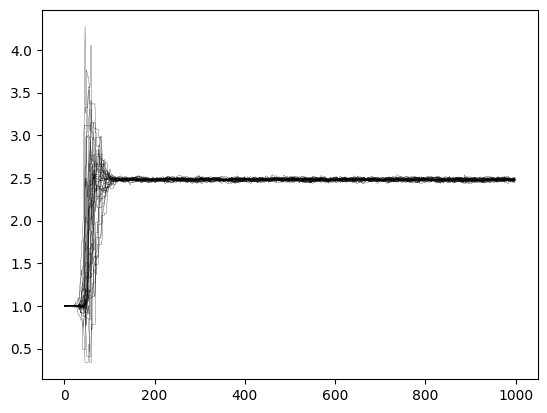

In [37]:
for i in range(ndim):
    pl.plot(samples[:,:,0], 'k', lw=0.1, )

to get statistical properties of the chains I will concatenate the 32 chains.
This works _iff_ the chains are independent - see about it in the slides!

note: the chains are _assumed_ to be independent


the first 100 points are where the chains are "burning in" and we will throw them away (`discard=100`) - see slides!!
`flat=True` does the concatenation


In [38]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian


In [39]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])

print(f"slope {mcmc[0][1]:.2f} [{mcmc[0][0]:.2f}-{mcmc[0][2]:.2f}]")
print(f"intercept {mcmc[1][1]:.2f} [{mcmc[1][0]:.2f}-{mcmc[1][2]:.2f}]")

slope 2.48 [2.47-2.49]
intercept 8.60 [8.56-8.64]


plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters


In [40]:
!pip install corner


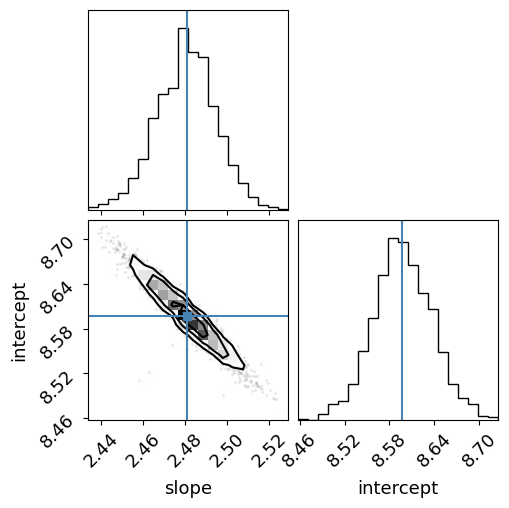

In [41]:
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["slope", "intercept"], truths=mcmc[:,1]);


WRITE YOUR OWN CAPTION HERE!

Caption is revised by AI:

This Corner plot shows the posterior distributions of the slope and intercept parameters  obtained from MCMC sampling the linear regression model. The distributions are narrow with good convergence/fitting and small parameter uncertainties. The diagonal panels display 1D histograms of each parameter's marginal posterior distribution, while the off-diagonal panel shows the 2D joint posterior distribution revealing parameter correlations. A mild negative correlation between slope and intercept is visible, and the blue lines marking the true values lie at the peaks of the posteriors, confirming that the MCMC fit is stable and consistent with the best-fit solution.

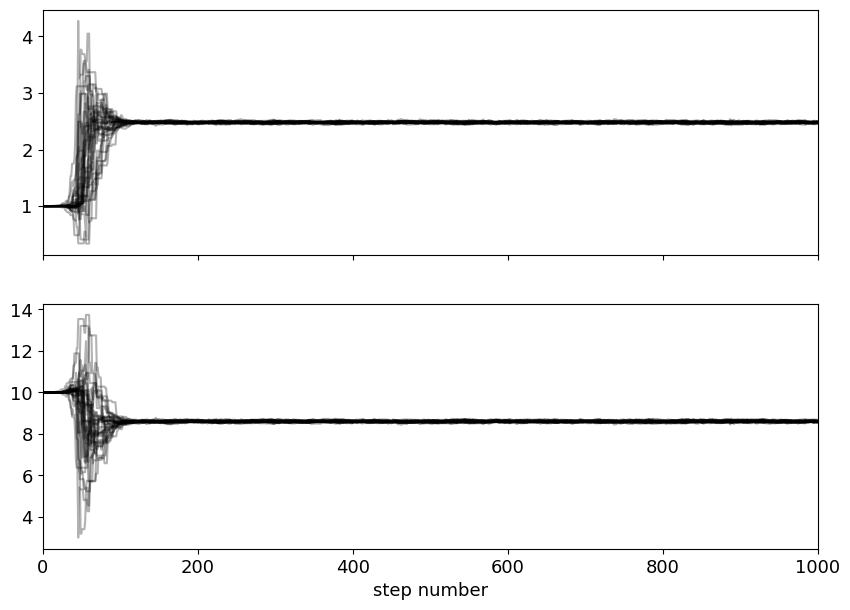

In [42]:
# the chains should be plotted as well. here is a better plot of the chains
#in the slides and in class I discussed what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

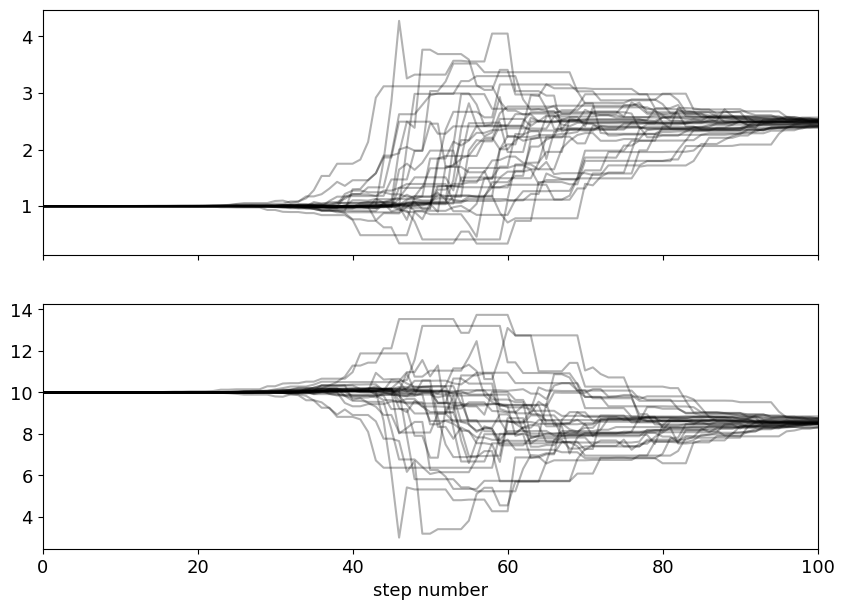

In [43]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [44]:
# save the mcmc results for later
mcmc_line = mcmc
mcmc_line

array([[2.46656439, 2.48086122, 2.49437468],
       [8.55915811, 8.59681075, 8.63689299]])

Text(0.5, 0, 'log time')

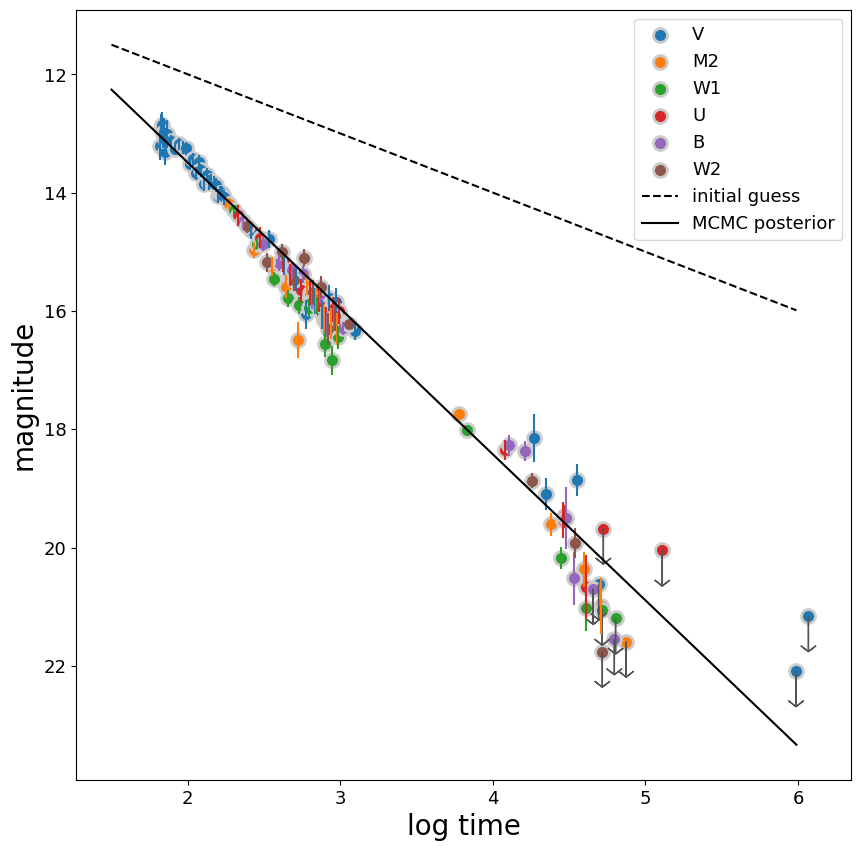

In [48]:
labels = ["slope", "intercept"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        line(10, 1, (np.arange(1.5,6,0.01))),
        #line(ig[1], ig[0], 10**np.arange(1.5,6,0.01)),
        ls="--", c="k",
        label="initial guess")

ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="k",
        label="MCMC posterior")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

#pl.ylim(24.5,11.7)
#pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20)

Photometric observations of the GRB afterglow in magnitude–logtime space. The dashed line represents the initial guess for the linear model parameters (slope = 1, intercept = 10), while the solid line shows the best-fit posterior model obtained from MCMC sampling. The initial guess fails to fit the data because it assumes a shallower decay and brighter intercept than the observed afterglow, lying well above the measured points at early times and diverging further at later times. In contrast, the MCMC posterior  provides a much better match to the data across the entire time range, capturing both the slope and offset consistent with the multi-band afterglow decay.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [49]:
# NOTE: this model is not in log time!!
t = grbAGnouplim.time.values

In [50]:
t.min(), t.max()

(np.int64(66), np.int64(51257))

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [51]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable (time)
    Return:
      model predictions for each x (array like)
    """
    a1, a2, b, Tb = theta
    ratio = x / Tb
    #bpl_model = b - np.log10((x / Tb)**(-a1) + (x / Tb)**(-a2))
    term1 = ratio**(-a1)
    term2 = ratio**(-a2)

    #option2
    # Add a small epsilon to x and b to avoid division by zero or log of zero
    #epsilon = 1e-10
    #return b - np.log10(((x + epsilon) / (Tb + epsilon))**(-a1) + ((x + epsilon) / (Tb + epsilon))**(-a2))

    #Option1
    bpl_model = b - np.log10(term1 + term2)
    return bpl_model

    #no difference for these two options

In [52]:
def bpl_chi2(theta, x, y, s):
    bpl_model = bpl(theta, x) # Calculate the model prediction
    return np.sum((bpl_model - y)**2 / s**2)


# t= grbAGnouplim.time.values: defined sooner
x=t
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values


In [ ]:
#remember the chi square:
# Sum((model - data)/error)^2 is a quantity that follows a chi square distribution with N=number of degreed of freedom.
# Divide it by the number of degreed  of freedom as Chisq = (Sum((model - data)/error)^2)/DOF
# If it is ~1 that is a good model.
# >1 bad model
# <1 your errors must be underestimated (model too good to be true!)

In [53]:
#log likelihood for bpl
def log_likelihood_bpl(theta, x, y, s):
   bpl_model = bpl(theta, x) # Calculate the model prediction
   return -np.sum(((y - bpl_model)**2) / s**2)

In [54]:
#log prior for bpl
def log_prior_bpl(theta):
    """
    theta = [ a1, a2, b, Tb]
        Tb : break time            (must be t.min() <Tb <t.max() )
        a1 : early-time slope      (mag should increase with time -> a1 > 0)
        a2 : late-time slope       (typically steeper than early -> a2 > a1 > 0)
        b  : magnitude offset      (keep positive and reasonable)
    Returns log-prior: 0 inside allowed region, -inf otherwise.
    """
    a1, a2, b, Tb = theta
    if a1 > 0 and a2 > 0 and b>0 and t.min() < Tb < t.max() :
        return 0.0
    return -np.inf

In [55]:
#log posterior for BPL
def log_posterior_bpl(theta, x, y, s):
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood_bpl(theta, x, y, s) # Use log_likelihood_bpl

In [ ]:
def log_likelihood_bpl(...):
  # use the same log_likelihood as before (chi2) but with the new model
  ...
def log_prior_bpl(...):
  # similar to before, but choose relevant regions of avoidance based on the description of the model
  ...
def log_posterior_bpl(...):
  #this is the same as before! exactly! cause this is just log_likelihood + log_prior
  ...

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [56]:
ig = [.2, 5, 20, 1000]

# Define the negative log likelihood function to minimize
def neg_log_likelihood_bpl(theta, x, y, s):
    return -log_likelihood_bpl(theta, x, y, s)

# Use minimize to find the parameters that minimize the negative log likelihood
soln = minimize(neg_log_likelihood_bpl, ig, args=(x, y, s))
soln

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 217.46531456110094
        x: [ 3.548e+00  2.146e+00  1.505e+01  2.736e+02]
      nit: 72
      jac: [ 9.537e-06  7.629e-06 -7.629e-06  9.537e-06]
 hess_inv: [[ 3.324e-03 -6.175e-04  4.184e-04 -1.403e-03]
            [-6.175e-04  3.802e-04 -1.531e-04  1.219e-04]
            [ 4.184e-04 -1.531e-04  1.629e-04 -1.612e-04]
            [-1.403e-03  1.219e-04 -1.612e-04  2.412e-03]]
     nfev: 490
     njev: 98

Based on the physics of the BPL , the pre-break power (3.548e+00)is less than the post-break, therefore, here a1 must show the post break and a2 the prebreak power(2.146e+00 )

Text(0, 0.5, 'Magnitude')

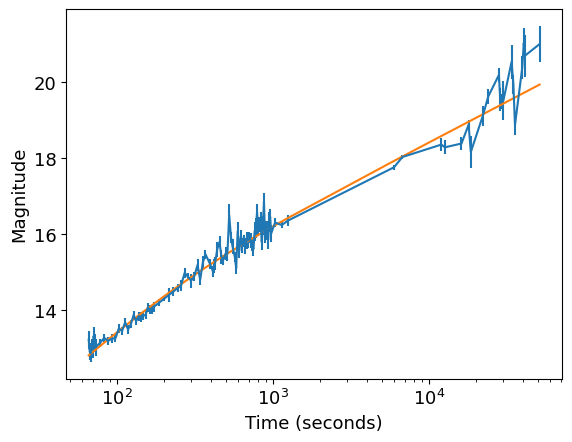

In [57]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s)
pl.plot(x, bpl(ig, x))
pl.xscale("log")
pl.xlabel('Time (seconds)')
pl.ylabel('Magnitude')

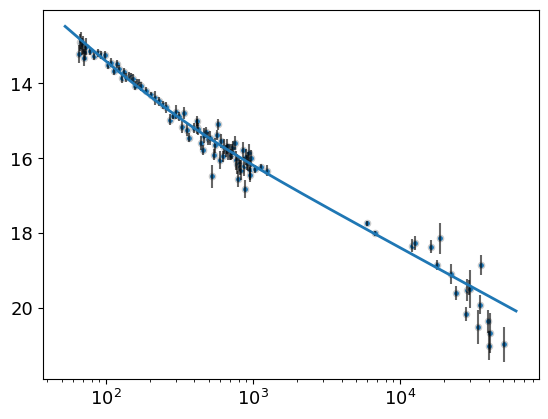

In [ ]:
ig= soln.x
tt = np.logspace(np.log10(x.min()*0.8), np.log10(x.max()*1.2), 500)
plt.errorbar(x, y, yerr=s, fmt='.', ms=0, color='k', alpha=0.6)
plt.scatter(x, y, s=20, edgecolor='#ccc')
plt.plot(tt, bpl(ig, tt), lw=2)
plt.xscale('log'); plt.gca().invert_yaxis()
plt.show()


# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [58]:
# set the emcee hyperparameters
#pos = ...

#nwalkers, ndim = ...

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_bpl, args=(x, y, s))

In [59]:
# set the emcee hyperparameters for BPL
# Use the initial guess from the minimization
ig = soln.x

# set the number of dimensions and walkers for BPL
ndim_bpl = len(ig) # Should be 4 for BPL (a1, a2, b, Tb)
nwalkers = 32 # Or choose a suitable number, typically > 2*ndim

#form mcmc for line-model:
# the starting point for each walker is a small perturbation of the initial guess
pos = ig + 1e-4 * np.random.randn(nwalkers, ndim_bpl)


sampler_bpl = emcee.EnsembleSampler(nwalkers, ndim_bpl, log_posterior_bpl, args=(x, y, s)) # Use log_posterior_bpl not chi2!

In [60]:
# run the model
sampler_bpl.run_mcmc(pos, 3_000, progress=True); #for linear mcmc stepnumber was 1000

100%|██████████| 3000/3000 [00:06<00:00, 437.43it/s]


In [61]:
samples = sampler_bpl.get_chain()

In [62]:
samples.shape

(3000, 32, 4)

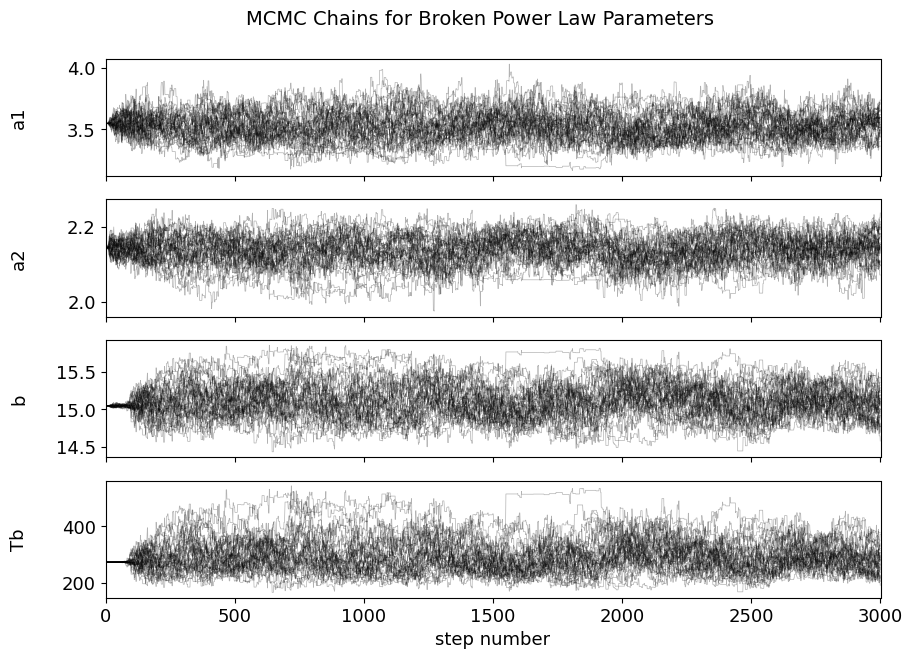

In [63]:
#plot the chains
# Use ndim_bpl for the BPL model
fig, axes = plt.subplots(ndim_bpl, figsize=(10, 7), sharex=True)

# Parameter labels for BPL model
#  the order in theta  is (a1, a2, b, Tb)
param_labels = ["a1", "a2", "b", "Tb"]


for i in range(ndim_bpl):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3, lw=0.5)
    ax.set_ylabel(param_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5) #from diymcmc
    ax.set_xlim(0, len(samples)) #from diymcmc
    plt.suptitle("MCMC Chains for Broken Power Law Parameters", fontsize=14, y=0.95)
axes[-1].set_xlabel("step number");

Given is MCMC trace plots for the broken power-law (BPL) model parameters ($a_1, a_2, b, T_b$). Each panel shows the walker histories across
∼3000 steps, illustrating stable mixing around stationary means. Here, $a1$ and $a2$
 denote the post-break and pre-break temporal power indices, respectively. This comes from   the physical expectation that the afterglow decay steepens after the break: the recovered post-break index is $a_1$
≈3.548, which is larger than the pre-break index $a_2$
≈2.146. The intercept-like term
b≈15 sets the magnitude normalization, and $$T_b$
 marks the break time (in the same time units as the data). Overall, the chains exhibit good mixing without obvious trends, supporting convergence of the sampler for all four parameters. Another noticeable feature  is that all four parameters have reached apparent convergence and exhibit stable, well-mixed chains without long-term trends or drifts, validating the broken power-law interpretation of the afterglow light curve.

In [ ]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = ...
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = ...
mcmc[:,1]

In [67]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples_bpl = sampler_bpl.get_chain(discard=500, thin=15, flat=True)
mcmc = np.zeros((ndim_bpl, 3))
for i in range(ndim_bpl):
    mcmc[i] = np.percentile(flat_samples_bpl[:, i], [16, 50, 84])
mcmc_bpl = mcmc
print(mcmc_bpl[:,1]) # Print the median (50th percentile) values

[  3.51818562   2.13887779  15.09861737 285.67652714]


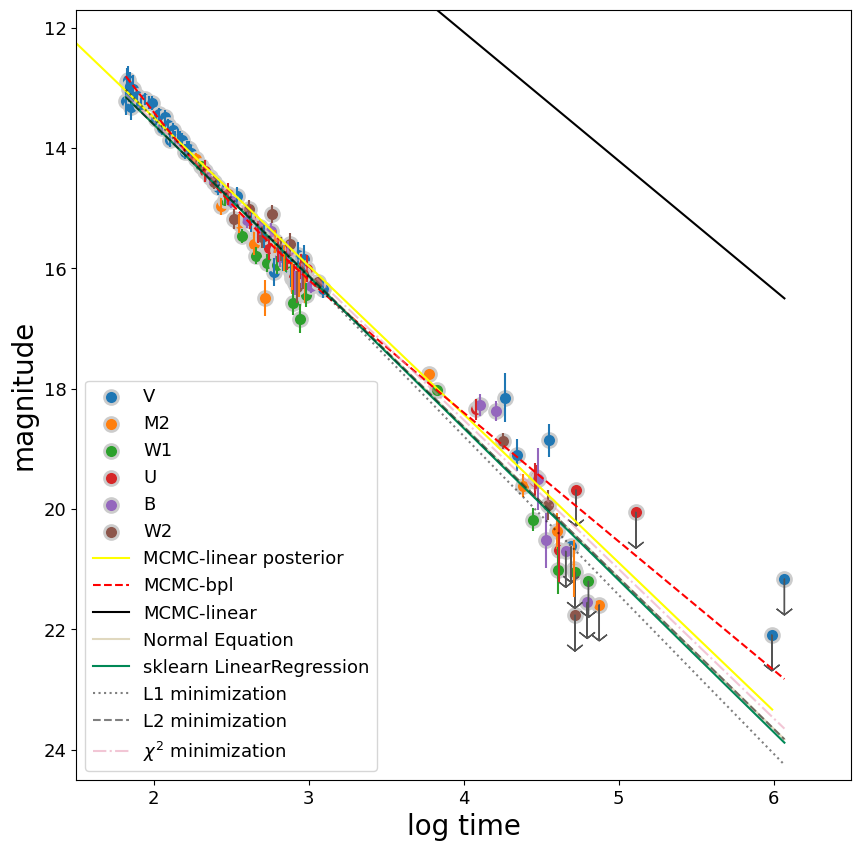

In [75]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

#MCMC
ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="yellow",
        label="MCMC-linear posterior")
ax.plot(grbAG.logtime.values, bpl(mcmc[:,1],
                            grbAG.time.values), ls="--", c="red", label="MCMC-bpl")

ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1],
                            grbAG.logtime.values), ls="-", c="k", label="MCMC-linear")


#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Photometric observations of the GRB afterglow in magnitude–logtime space. See the caption of previous GRB plot for general considerations.  The unique featur here is the MCMC_pbl model that shows a noticeable different slope at later time , after the time-interval 3-4, where the data deviate systematically from a single linear trend. This  motivates the transition to a broken power-law (BPL) model, where two distinct decay slopes (pre- and post-break) more faithfully describe the afterglow’s temporal evolution.

## plot the marginalized posterior distributions of the parameters

Text(0.5, 1, 'Marginalized Posterior Distributions - Broken Power Law Parameters')

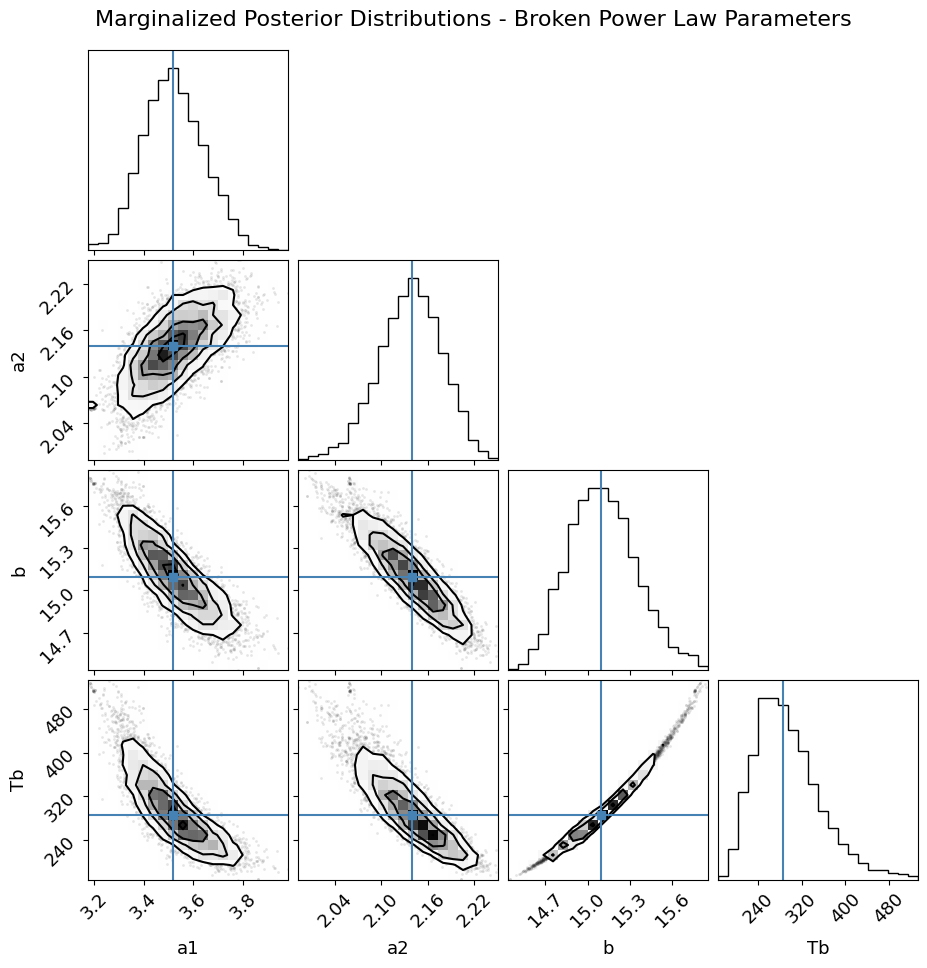

In [76]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples_bpl, labels=["a1", "a2", "b", "Tb"], truths=mcmc[:,1]);

plt.suptitle("Marginalized Posterior Distributions - Broken Power Law Parameters",
             fontsize=16, y=1)



Corner plot showing the marginalized posterior distributions for the broken power-law (BPL) model parameters
(a1, a2, b, Tb). Each diagonal panel displays the one-dimensional posterior for an individual parameter, while
the off-diagonal panels show the two-dimensional covariances between parameter pairs. Blue lines mark the
median (best-fit) values from the MCMC posterior.

The results clearly show that the post-break slope (a1 ≈ 3.55) is steeper than the pre-break slope
(a2 ≈ 2.15), confirming the expected steepening of the GRB afterglow decay after the temporal break. The
intercept parameter (b ≈ 15) defines the normalization of the light curve, and the break time (Tb ≈ 300) marks
the transition point between the two power-law regimes.

A particularly noticeable feature is the very narrow and strongly tilted correlation between b and Tb. This
arises from the mathematical continuity constraint of the BPL model: to ensure the two power-law segments
connect smoothly, the intercept b must shift precisely as Tb changes according to the relation
b' = b + (a2 - a1) * log10(Tb). As Tb increases, b decreases to preserve the smooth connection, producing a
tight negative correlation. In contrast, the broader ellipses seen for pairs such as (a1, a2) or (a1, Tb)
reflect physical parameter trade-offs during fitting, rather than strict analytic coupling.

Overall, the well-behaved, stationary contours confirm that the MCMC sampling converged successfully and
captured meaningful posterior correlations consistent with the physics of a smoothly broken power-law decay
in GRB afterglow light curves.



EXTRA CREDIT FOR 461 REQUIRED FOR 661

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in https://slides.com/d/Ql12kB4/live#/11. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)


- implement the calculation of the likelihood ration, which is expected to be chisq distributed following a chisq distribution with k degrees of freedom where k is the difference in number of parameters.

- implement the caluculation of the AIC (https://slides.com/d/Ql12kB4/live#/11/6
- and BIC (https://slides.com/d/Ql12kB4/live#/11/8)



In [77]:
print("Linear-model log likelihood: {:.2f}".format(
    log_likelihood(mcmc_line[:,1], grbAGnouplim.logtime.values, y, s)))  #.2f= 2 dicimal digits, .3f = 3 digits

Linear-model log likelihood: -317.43


In [80]:
print("BPL-model log likelihood: {:.2f}".format(
    log_likelihood_bpl(mcmc_bpl[:,1], grbAGnouplim.time.values, y, s))) #3dicimal digits, grbAGnouplim.time.values=x_nolog

BPL-model log likelihood: -217.50


In [ ]:
print("..."... log_likelihood(mcmc_line[:,1], x, y, s)) #control the decimal digits!

In [ ]:
print("..."... log_likelihood_bpl(mcmc[:,1], x_nolog, y, s))

## Implement the likelihood ratio test printing out the likelihood ratio statistics https://slides.com/d/Ql12kB4/live#/11/2

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [81]:
"""
M1 = restricted model (linear model, theta with 2 parameters)

M2 = full model (BPL model, 4 parameters)

L(M1) = likelihood of linear model = L1 =log_likelihood

L(M2) = likelihood of BPL model =L2 = log_likelihood_bpl

Likelihood Ratio=LR

LR = -2 * ln[L(M1) / L(M2)]=  -2 * ln[L1 / L2] = -2 * [ln(L1) - ln(L2)]
     = -2 * L1 + 2 *L2

The test statistic follows chi2 distribution with:
degrees of freedom = 4 - 2 = 2 (BPL has 4 params, linear has 2 params)


"""


'\nM1 = restricted model (linear model, theta with 2 parameters)\n\nM2 = full model (BPL model, 4 parameters)\n\nL(M1) = likelihood of linear model = L1 =log_likelihood\n\nL(M2) = likelihood of BPL model =L2 = log_likelihood_bpl\n\nLikelihood Ratio=LR\n\nLR = -2 * ln[L(M1) / L(M2)]=  -2 * ln[L1 / L2] = -2 * [ln(L1) - ln(L2)]\n     = -2 * L1 + 2 *L2\n\nThe test statistic follows chi2 distribution with:\ndegrees of freedom = 4 - 2 = 2 (BPL has 4 params, linear has 2 params)\n\n\n'

In [82]:
def like_ratio_statistics(L1, L2):
  return -2*(L1) + 2*(L2)

like_ratio_statistics(log_likelihood(mcmc_line[:,1], grbAGnouplim.logtime.values, y, s),
                      log_likelihood_bpl(mcmc[:,1], grbAGnouplim.time.values, y, s))

np.float64(199.85703531388577)

# CHOOSE THE BEST MODEL IN THE NHRT FRAMEWORK


write out the first 4 steps of the NHRT:
- state the null
- state the alternative
- choose the threshold
- choose the test (OK, I did that for you!)
- measure the test statistics (pivotal quantity)
- get the p-value

_see if you can get the p-value from the table
I WILL NOT TAKE POINTS OFF IF YOU GET IT WRONG, but I want you to try and figure out how to read the table in https://slides.com/d/Ql12kB4/live#/11/2 to get a p-value out of your likelihood ratio statistics. Try your best!_

- use that p-value to see if you can or cannot reject the null and clearly state your conclusions



**1. The null hypothesis (H₀)**: *simpler model is preferable*

The restricted linear model (with 2 parameters) is enought to describe the GRB afterglow data well, and no need for a more complex model, like the broken power law model.

**2. The alternative hypothesis (H₁):**

The broken power law model (with 4 parameters) provides a significantly better fit to the GRB afterglow data than the linear model.


**3.The threshold (significance) level:**

α = 0.05 (95% confidence level): as it was usual in previous sessions

**4. The test statistics:**

Likelihood ratio test give above



The table was not readable, so I asked AI to retype the row with df=2


The table below gives the value $\chi^2_0$ for which $P[\chi^2 < \chi^2_0] = P$ for a given number of degrees of freedom and a given value of $P$.


| **Degrees of Freedom ** | **P = 0.010** | **P = 0.050** | **P = 0.100** | **P = 0.500** | **P = 0.900** | **P = 0.950** | **P = 0.990** |
|:---------------------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
| **2** | 0.020 | 0.103 | 0.211 | 1.386 | 4.605 | 5.991 | 9.210 |

The table  provides critical values for chi2 distribution; for instance, a value of 5.991 is so high that only 5% (1-P = 1- .95) of random data would exceed it

Here $\chi^2$ = $\lambda_{LR}$ $≈$199.86, which is much larger than all the critical chi2 values in the table!!!

p-value = P[χ² ≥ 199.86] = 1 - P[χ² < 199.86] ≈ 1 - 1 = 0

 This shows overwhelming statistical evidence to reject the simple linear model in favor of the Broken Power Law, meaning that the GRB afterglow light curve has a statistically significant break that the only complex model successfully captures it.

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [ ]:
"""

   with
        N: number of observations = length of x
        L : log-likelihood
        k : number of parameters: 2 or 4


    AIC = -(2/N) * log(L) + (2/N) * k = (2/N) * (k -L)
    BIC = -2 * log(L) + log(N) * k

     From the slides : '-' sign infront of likelihood = aic shrinks for better models
    """


In [83]:
x=grbAGnouplim.logtime.values
x_nolog=grbAGnouplim.time.values

In [84]:
def aic( x, L, k):
    return (2/n) * (k - L)

def bic( x, L, k):
    return np.log(n) * k - 2 * L

n = len(x)

In [85]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc_bpl[:,1], x_nolog, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc_bpl[:,1], x_nolog, y, s), 4)))

AIC line 5.92 - AIC bpl 4.10
BIC line 644.22 - BIC bpl 644.22


adding more prameters =more complexity= penalty for that!

is it why BIC bpl is the same as bic-line??

 **Summary of GRB Afterglow Model Comparison**

*Key Results:*

Likelihood Ratio Test: λ_LR = 199.86 (p ≈ 0)

AIC: Linear = 5.92, BPL = 4.10 (is better as it is smaller) (ΔAIC = 1.82)

BIC: Both models = 644.21 (ΔBIC = 0)

**Model Selection:**

Likelihood Ratio Test: STRONGLY favors BPL

AIC: Slightly favors BPL (ΔAIC = 1.82 suggests weak preference)

BIC: Seems inconclusive !?

**Overall Assessment:**

Despite the inconsistencies in BIC calculations, the overwhelming evidence from the likelihood ratio test (λ_LR = 199.86, p ≈ 0, if these results are reliable from my code!?) provides conclusive evidence that:

"GRB afterglow requires a broken power law model to adequately describe its  decay pattern. The data provide  statistical evidence for a break in the light curve, supporting standard GRB afterglow physics."

# Extra Credit (Extra for everyone)
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model

In [ ]:
"""
polynomial function: y = p0 + p1*x + p2*x² + p3*x³+....+pn*xn
y = p0 + p1*x + p2*x² + p3*x³

"""

In [92]:
def polynomial(theta, x):
    """
    Builds a polynomial of arbitrary degree.

    Input:
      theta: (array like) polynomial coefficients [p0, p1, p2, ...]
      x: (array like) independent variable
    Return:
      model predictions for each x (array like)
    """
    # Ensure theta is a numpy array for easier manipulation
    theta = np.asarray(theta)

    # Initialize the polynomial with the constant term
    poly_model = theta[0] #Starts with the constant term: p₀


    #Loops through remaining coefficients: p1, p2, p3,...
    #and builds polynomial: p₀ + p₁·x + p₂·x² + p₃·x³ + ...
    for i in range(1, len(theta)):
        poly_model += theta[i] * (x**i) #Adds each polynomial term, like p₁·x = linear term ( slope parameter) and p₂·x² = quadratic term  and ...

    return poly_model

In [94]:
def chi2_poly(theta, x, y, s):
    """
    Chi-squared function for polynomial fitting

    Input:
      theta: polynomial coefficients [p0, p1, p2, ...]
      x: independent variable (time)
      y: observed magnitudes
      s: measurement uncertainties
    Return:
      chi-squared value
    """
    return np.sum((y - polynomial(theta, x))**2 / s**2)

In [95]:
# Choose an initial guess for the polynomial coefficients
# For a polynomial of degree n, you need n+1 coefficients
# Let's start with a 2nd-degree polynomial (ax^2 + bx + c)
# Initial guess: [c, b, a] (constant, x coefficient, x^2 coefficient)
initialGuess_poly = [20, -5, 0.5]

# Define x, y, and s from the data without upper limits
x_poly = grbAGnouplim.logtime.values # Using logtime for polynomial fit
y_poly = grbAGnouplim.mag.values
s_poly = grbAGnouplim.magerr.values

In [96]:
#Use minimize to find the best-fit parameters
chi2_poly_solution = minimize(chi2_poly, initialGuess_poly, args=(x_poly, y_poly, s_poly))

In [98]:
 #Extract the best-fit parameters
best_fit_poly_params = chi2_poly_solution.x


print("Best-fit polynomial parameters (c, b, a for ax^2 + bx + c):", best_fit_poly_params)

Best-fit polynomial parameters (c, b, a for ax^2 + bx + c): [ 6.56383351  3.9088593  -0.23419164]


In [100]:
 #Evaluate the fit by calculating the chi-squared value
chi2_poly_best_fit = chi2_poly(best_fit_poly_params, x_poly, y_poly, s_poly)
print("Chi-squared value for the best-fit polynomial model:", chi2_poly_best_fit)

Chi-squared value for the best-fit polynomial model: 244.9536015082383


In [103]:
#  Compare to the BPL model's chi-squared
# we have already calculated the BPL chi-squared (negative log likelihood)
# The negative log likelihood of the BPL model is -log_likelihood_bpl(mcmc_bpl[:,1], grbAGnouplim.time.values, y, s)
# Note: The BPL model was fitted in natural time, while this polynomial is in log time.
# For a direct comparison, you might need to fit the polynomial in natural time as well, or compare using AIC/BIC.
# Let's compare the chi-squared values directly for now, acknowledging the different time bases.

# The BPL chi-squared value from your previous calculation (which was -log_likelihood_bpl)
chi2_bpl_best_fit = -log_likelihood_bpl(mcmc_bpl[:,1], grbAGnouplim.time.values, y, s)
print("Chi-squared value for the best-fit BPL model:", chi2_bpl_best_fit)

Chi-squared value for the best-fit BPL model: 217.4971778551703


In [104]:
 #Simple comparison
if chi2_poly_best_fit < chi2_bpl_best_fit:
    print("The polynomial model (in log time) provides a better fit based on chi-squared.")
else:
    print("The BPL model (in natural time) provides a better fit based on chi-squared.")

# Further steps would involve plotting the polynomial fit and potentially comparing models using AIC/BIC.

The BPL model (in natural time) provides a better fit based on chi-squared.
